Extracting returns signals from Microsoft's LOB for OB data for April 2018
===

In [1]:
import os
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
import statsmodels.formula.api as smf
from glob import glob
from datetime import datetime
import tensorflow as tf
import keras
from keras import Input, layers
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, LeakyReLU, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
import random
from sklearn.metrics import mean_squared_error as mse
from scipy import stats
from sklearn.linear_model import LinearRegression
from fireTS.models import NARX
seed_value = 2020
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
from sklearn.preprocessing import QuantileTransformer 
normalizer = QuantileTransformer(output_distribution='normal')

Initialising some utility functions, extracting data from LOBster data, calculation of cumulative returns over the month
===

In [2]:
#utils functions
def midPrice(lob_data):
    a=lob_data['AP1'].values.tolist()
    b=lob_data['BP1'].values.tolist()
    m=np.zeros(len(a))
    for i in range(len(a)):
        m[i]=(a[i]+b[i])/2
    return m
def upDown(m):
    u_d=np.zeros(len(a))
    for i in range(1,len(a)):
        if m[i-1]>m[i]:#scende il prezzo
            u_d[i-1]=-1
        elif m[i-1]<m[i]:#sale il prezzo
            u_d[i-1]=1
        else:
            u_d[i-1]=0
    return u_d

def ret(m):
    r=np.zeros(len(m))
    for i in range(1,len(m)):
        r[i]=m[i-1]-m[i]
    return r

def deltaT(m):
    N=0
    d=np.zeros(len(m))
    for i in range(1,len(m)):
        d[i]=m[i-1]-m[i]
        if [i]!=0:
            N+=1
    return int((2.34*10**7)/N)

def doHk(deltT,k):
    hk=np.zeros(k)
    for i in range(k):
        hk[i]=np.int16((1/5)*i*deltT)
    return hk

def retHk(m,hk):
    ret=np.zeros(100)
    for i,k in zip(range(len(m)),hk):
        ret[i]=m[i+k]-m[i]
    return ret

def OF_1(ld):
    of=np.zeros((len(ld),6))
    for i,ii in zip(range(1,12,2),range(0,6,2)): #giro sui prezzi ask e volumi ask di conseguenza
        for j in range(1,len(ld)): #giro sulle righe
            #ask
            if ld[j][i-1]>ld[j-1][i-1]: #p_t>p_t-1
                of[j-1][ii]=-1*ld[j][i]
            elif ld[j][i-1]<ld[j-1][i-1]: #p_t<p_t-1
                of[j-1][ii]=ld[j][i]
            elif ld[j][i-1]==ld[j-1][i-1]: #p_t=p_t-1
                of[j-1][ii]=ld[j][i]-ld[j-1][i]
    for w,ww in zip(range(3,12,4),range(1,7,2)):
        for jj in range(1,len(ld)):    
            #bid
            if ld[jj][w-1]>ld[jj-1][w-1]: #p_t>p_t-1
                of[jj-1][ww]=ld[jj][w]
            elif ld[jj][w-1]<ld[jj-1][w-1]: #p_t<p_t-1
                of[jj-1][ww]=-1*ld[jj][w]
            elif ld[jj][w-1]==ld[jj-1][w-1]: #p_t=p_t-1
                of[jj-1][ww]=ld[jj][w]-ld[jj-1][w]
    return of
    
from scipy import stats
def taglia_e_cuci(v):
    hi=np.quantile(v,0.005)
    lo=np.quantile(v, 0.995)
    b=np.clip(v, hi,lo)
    return b

In [3]:
lob_data=pd.read_csv('/Users/macri/Desktop/MSFT_OF.csv')
lob_data.drop(['idx'], axis=1,inplace=True)
lob_data.reset_index(drop=True,inplace=True)

In [4]:
C= int(len(lob_data)*0.06)
b=lob_data.iloc[ :C].copy()
ld=b.values.tolist()
lob_data=b
ld=lob_data.values.tolist()
aa=OF_1(ld) #fa Order Flow
bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
of_data=pd.DataFrame(aa, columns=bCols)
m=pd.DataFrame(midPrice(lob_data),columns=['m'])


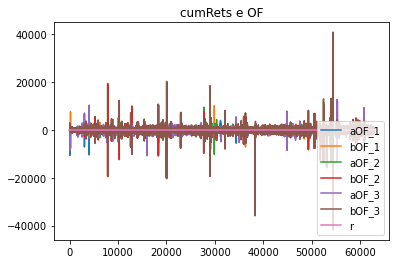

In [5]:
m['r']=(m['m']/10**4).pct_change()
m['rCum']=m['r']#.cumprod()-1
of_data  ['r']= m['rCum']#.diff()# (1 + m['r']).cumprod() - 1#m['rCum']
of_data.fillna(0).copy()
of_data.plot()
plt.title('cumRets e OF')
plt.show()

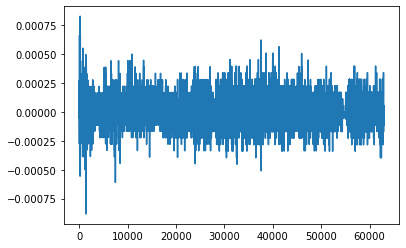

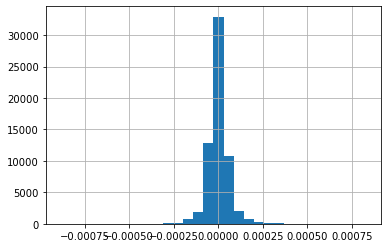

In [6]:
rr=(of_data['r'])/of_data['r'].std()
of_data['r'].plot()
plt.show()
of_data['r'].hist(bins=30)
plt.show()

Prepares the dataset: cuts at 0.5% the tails, and splits data in the requested formats
===

In [7]:
offlo=of_data.apply(lambda x: taglia_e_cuci(x))
offlo=offlo.fillna(0)

In [8]:
def prepare_x_y(data, lag, dimension):
    data = data
    shape = data.shape
    X = np.zeros((shape[0]-lag, lag, dimension))
    Y = np.zeros((shape[0]-lag))
    for i in range(shape[0]-lag):
        X[i] = data[i:i+lag, :dimension] # take the variables' columns as features
        Y[i] = data[i+lag, -1:] # take the last column as dep var
    X = X.reshape(X.shape[0], lag, dimension, 1)
    Y = Y.reshape(Y.shape[0])
    return X,Y

In [9]:
train_weight=0.9
vali_weight=0.05

n_train     =offlo.iloc[:int(len(of_data)*train_weight)]
n_vali      =offlo.iloc[int(len(of_data)*train_weight):-101]#int(len(of_data)*train_weight)+int(len(of_data)*vali_weight)
n_test      =offlo.iloc[-101:]#int(len(of_data)*train_weight)+int(len(of_data)*vali_weight)
#n_train=taglia_e_cuci(train)
#n_vali =taglia_e_cuci(validation)
#n_test =taglia_e_cuci(test)



#for col in train.columns:#'aOF_1',	'bOF_1',	'aOF_2',	'bOF_2',	'aOF_3',	'bOF_3']:
#    mu = float(train.loc[:,col].mean())
#    sigma = float(train.loc[:,col].std())
#    stdize_input = lambda x: (x-mu)/sigma #stats.zscore(n_train)#normalizer.fit_transform((x.values.reshape(-1,1)))##n_train: stats.zscore(n_train)

x_vars=['aOF_1',	'bOF_1',	'aOF_2',	'bOF_2',	'aOF_3',	'bOF_3']
for x_var in x_vars:
    sd = n_train[x_var].std()
    mu = n_train[x_var].mean()
    std = lambda x: (x-mu)/sd 
    n_train.loc[:,x_var] = (n_train.loc[:,x_var]-mu)  / sd
    n_vali .loc[:,x_var] = (n_vali .loc[:,x_var]-mu)  / sd
    n_test .loc[:,x_var] = (n_test .loc[:,x_var]-mu)  / sd#.loc[:,x_var] = (n_test .loc[:,x_var]-mu)  / sd

#n_train['r'] = n_train['r'].diff().fillna(0) 
#n_vali ['r'] = n_vali ['r'].diff().fillna(0) 
#n_test ['r'] = n_test ['r'].diff().fillna(0) 

#std_train['r']=n_train.apply(stdize_input)
#std_vali ['r']=n_vali .apply(stdize_input)
#std_test ['r']=n_test .apply(stdize_input)
#
#std_train['spread']=y[:int(len(of_data)*train_weight)]
#std_vali ['spread']=y[int(len(of_data)*train_weight):int(len(of_data)*train_weight)+int(len(of_data)*vali_weight)]
#std_test ['spread']=y[int(len(of_data)*train_weight)+int(len(of_data)*vali_weight):]




n_train.head(),n_vali.head(),n_test.head()

C:\Users\macri\AppData\Local\Temp\ipykernel_17896\1098276775.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_train.loc[:,x_var] = (n_train.loc[:,x_var]-mu)  / sd
C:\Users\macri\AppData\Local\Temp\ipykernel_17896\1098276775.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  n_vali .loc[:,x_var] = (n_vali .loc[:,x_var]-mu)  / sd
C:\Users\macri\AppData\Local\Temp\ipykernel_17896\1098276775.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

(      aOF_1     bOF_1     aOF_2     bOF_2     aOF_3     bOF_3    r
 0 -1.025650  0.206257 -0.010122  0.098448  0.044919  0.077185  0.0
 1  0.099246  0.206257 -0.010122  0.098448  0.044919  0.077185  0.0
 2  0.099246  0.206257 -0.010122  0.098448  0.044919  0.077185  0.0
 3  0.099246  0.206257 -0.010122  0.098448  0.044919  0.077185  0.0
 4 -0.262457  0.206257 -0.010122  0.098448  0.044919  0.077185  0.0,
           aOF_1     bOF_1     aOF_2     bOF_2     aOF_3     bOF_3         r
 56622 -0.262457  0.206257 -0.010122  0.098448  0.044919  0.077185  0.000000
 56623 -1.423524  0.206257 -0.010122  0.098448 -2.428068  0.077185  0.000000
 56624 -1.709269  1.938513 -1.730210  1.686177 -1.809822  3.632737  0.000057
 56625 -0.262457  1.161546  0.938456  0.098448  0.044919  0.077185  0.000170
 56626 -0.262457  0.206257 -0.010122  0.098448  0.044919  0.077185  0.000000,
           aOF_1     bOF_1     aOF_2     bOF_2     aOF_3     bOF_3         r
 62813  0.099246 -0.112172 -0.326315  0.098448  0.0

In [10]:
trainX,trainY= prepare_x_y (n_train.to_numpy(),100,6)    #, 1   ,  100)
valiX ,valiY= prepare_x_y  (n_vali .to_numpy(),100,6)    #, 1   ,  100)
testX ,testY= prepare_x_y  (n_test .to_numpy(),100,6)    #, 1   ,  100)
print(trainX.shape ,trainY.shape)
print(valiX.shape  ,valiY .shape)
print(testX.shape  ,testY .shape)

(56522, 100, 6, 1) (56522,)
(6091, 100, 6, 1) (6091,)
(1, 100, 6, 1) (1,)


CNN/LSTM
===

In [11]:
#architettura della rete
def create_nn(T, NF,number_of_lstm):

    input_lmd = tf.keras.Input(shape=(T, NF, 1))

    conv_first1 = Conv2D(32, kernel_size=(1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    #
    layer_x = layers.Conv2D(filters=16, kernel_size=(10,1),strides=(1,10), padding='same')(conv_first1)
    layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
    # inception
    convsecond_1 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same', strides=(1,1))(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same', strides=(1,1))(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(layer_x)
    convsecond_3 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.7, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    #  LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)
    # output layer
    out = Dense(1, activation='leaky_relu')(conv_lstm)
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='mse')#, metrics=['accuracy']

    return model
  
deeplob = create_nn(100, 6, 64)

deeplob.summary()
checkpoint_filepath = './model_tensorflow2/weights'


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 6, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 100, 3, 32)   96          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 100, 3, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 3, 32)   4128        ['leaky_re_lu[0][0]']            
                                                                                              

In [12]:
callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)
saving = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

In [13]:
simple=deeplob.fit(trainX, trainY, validation_data=(valiX, valiY),  epochs=25, batch_size=500,callbacks=[callback,saving])

Epoch 1/25
114/114 [==============================] - 58s 498ms/step - loss: 9.2872e-05 - val_loss: 1.7268e-05
Epoch 2/25
114/114 [==============================] - 60s 528ms/step - loss: 9.7365e-06 - val_loss: 6.0310e-06
Epoch 3/25
114/114 [==============================] - 59s 517ms/step - loss: 3.9685e-06 - val_loss: 2.7895e-06
Epoch 4/25
114/114 [==============================] - 58s 510ms/step - loss: 1.9850e-06 - val_loss: 1.5301e-06
Epoch 5/25
114/114 [==============================] - 58s 508ms/step - loss: 1.2045e-06 - val_loss: 9.5706e-07
Epoch 6/25
114/114 [==============================] - 51s 451ms/step - loss: 7.3247e-07 - val_loss: 5.4943e-07
Epoch 7/25
114/114 [==============================] - 55s 478ms/step - loss: 4.9658e-07 - val_loss: 4.4442e-07
Epoch 8/25
114/114 [==============================] - 57s 500ms/step - loss: 3.3428e-07 - val_loss: 2.8568e-07
Epoch 9/25
114/114 [==============================] - 53s 463ms/step - loss: 2.5670e-07 - val_loss: 2.1000e-07
E

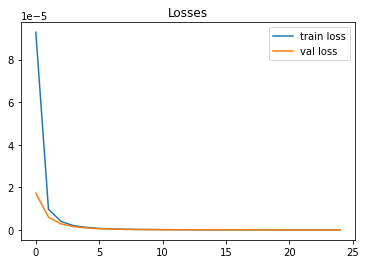

In [14]:
plt.plot(simple.history['loss'], label='train loss')
plt.plot(simple.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses');

In [15]:
Ptest = deeplob.predict(testX)

1/1 [==============================] - 0s 427ms/step


In [16]:
u=of_data['r'].mean()
true=testY
fcst=Ptest
num=((fcst-true))**2
den=((u-true))**2
r2OutS_modello=(1-num/den)/100
r2OutS_modello

array([[0.00658995]])

LSTM
===

In [18]:
#architettura della rete
num_units = 64
activation_function = 'leaky_relu'
adam = keras.optimizers.Adam(learning_rate=0.0001)
loss_function = 'mse'
batch_size = 250
num_epochs = 50
i = Input(shape=(100, 6))
x = LSTM(64, return_sequences=True)(i)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = LSTM(64, return_sequences=True)(x)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = LSTM(64, return_sequences=True)(x)
x = keras.layers.LeakyReLU(alpha=0.01)(x)
x = keras.layers.Dropout(0.7)(x, training=True)
#x = LSTM(64, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='leaky_relu')(x)


model = Model(i, x)


callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

model.compile(optimizer = adam, loss = loss_function)

lstmMSFT=model.fit(trainX, trainY, validation_data=(valiX, valiY),  epochs=25, batch_size=500,callbacks=[callback,saving])

Epoch 1/25
114/114 [==============================] - 178s 1s/step - loss: 3.3873e-05 - val_loss: 1.5159e-05
Epoch 2/25
114/114 [==============================] - 189s 2s/step - loss: 1.0267e-05 - val_loss: 9.0079e-06
Epoch 3/25
114/114 [==============================] - 167s 1s/step - loss: 6.6607e-06 - val_loss: 7.7655e-06
Epoch 4/25
114/114 [==============================] - 159s 1s/step - loss: 4.9936e-06 - val_loss: 6.1643e-06
Epoch 5/25
114/114 [==============================] - 159s 1s/step - loss: 4.1707e-06 - val_loss: 5.3397e-06
Epoch 6/25
114/114 [==============================] - 184s 2s/step - loss: 3.4998e-06 - val_loss: 5.1411e-06
Epoch 7/25
114/114 [==============================] - 155s 1s/step - loss: 3.0558e-06 - val_loss: 4.5071e-06
Epoch 8/25
114/114 [==============================] - 183s 2s/step - loss: 2.6032e-06 - val_loss: 3.8808e-06
Epoch 9/25
114/114 [==============================] - 194s 2s/step - loss: 2.2812e-06 - val_loss: 3.2264e-06
Epoch 10/25
114/114

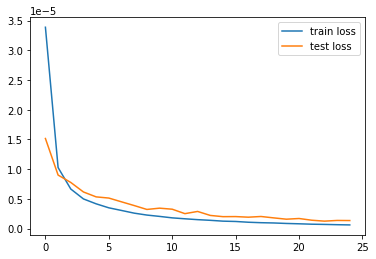

In [19]:
plt.plot(lstmMSFT.history['loss'], label='train loss')
plt.plot(lstmMSFT.history['val_loss'], label='test loss')
plt.legend()
plt.show()

In [20]:
PtestLSTM = model.predict(testX)

1/1 [==============================] - 2s 2s/step


In [21]:
u=of_data['r'].mean()
true=testY
fcst=PtestLSTM
num=((fcst-true))**2
den=((u-true))**2
R2LSTM=(1-num/den)/100
R2LSTM

array([[0.00600478]])

ARX-REGRESSION
===

In [22]:
y=                                                  (offlo['r'][:-1]).to_numpy()
x=    offlo[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']][:-1].to_numpy()
xFcst=offlo[['aOF_1','bOF_1','aOF_2','bOF_2','aOF_3','bOF_3']][-1:].to_numpy()
ytrue=                                              (offlo['r'][-1:]).to_numpy()



X=x.reshape(-1,6)
Y=y.reshape(-1)

mdl = NARX(LinearRegression(), auto_order=1, exog_order=[1,1,1,1,1,1])
mdl.fit(X,y)

y_forecast = mdl.forecast(X,y)
y_forecast,ytrue

(array([-0.00010102]), array([-0.00011348]))

In [23]:
mdl.score(X,Y, method='r2')

0.7007648673007507

In [26]:
u=offlo['r'].mean()
num=((y_forecast-ytrue))**2
den=((u-ytrue))**2
r2OutS_ARX=(1-num/den)
r2OutS_ARX

array([0.98786081])

In [25]:
dict={'ARX':-1.990231485216043*10**(-5),'LSTM':-0.002501,'CNN/LSTM':-0.00033487}
topl=pd.DataFrame([dict])
dd=np.zeros(3)
toplot=[r2OutSARX,
r2OutSLSTM,
r2OutS_modello]
for i in range(1,3):
    dd[i]=1/(toplot[i-1]-toplot[i])
plt.figure(figsize=(10,5))
plt.plot(toplot,'o-',label='estim. performance')
plt.annotate('ARX'     , (0.07,0))
plt.annotate('LSTM'    ,(.95,-0.0024))
plt.annotate('CNN/LSTM',(1.75,-0.00033487))
plt.ylabel('$R^2_{OS}(\%)=1- (MSE_{estim} / MSE_{bench})$')
plt.xlabel('models')
plt.grid(True)
plt.legend()
plt.savefig("MSFT_res.pdf")
plt.show()

NameError: name 'r2OutSARX' is not defined